In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#connnecting drive with google colab
from google.colab import drive
drive.mount('/content/drive/')
#read the csv file 
df=pd.read_csv('/content/drive/My  Drive/Colab Notebooks/Project/RELIANCE.NS (2).csv', parse_dates= ['Date'], index_col='Date')

Mounted at /content/drive/


In [4]:
df = df.dropna()

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,15.859429,15.944529,15.754989,15.917452,10.509540,48051995.0
1996-01-02,15.878770,15.956133,15.677626,15.793671,10.427814,77875009.0
1996-01-03,16.052837,16.783918,15.878770,15.913584,10.506987,96602936.0
1996-01-04,15.762726,15.813012,15.553845,15.766594,10.409934,100099436.0
1996-01-05,15.704703,15.704703,15.522900,15.658285,10.338424,76935930.0


In [6]:
df1=df.reset_index()['Close']

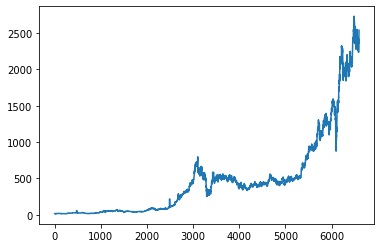

In [7]:
plt.plot(df1)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [10]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
76/76 [==============================] - 16s 146ms/step - loss: 7.8883e-04 - val_loss: 0.0030
Epoch 2/100
76/76 [==============================] - 11s 139ms/step - loss: 5.1228e-05 - val_loss: 0.0045
Epoch 3/100
76/76 [==============================] - 11s 139ms/step - loss: 4.8504e-05 - val_loss: 0.0041
Epoch 4/100
76/76 [==============================] - 10s 133ms/step - loss: 4.5004e-05 - val_loss: 0.0058
Epoch 5/100
76/76 [==============================] - 10s 135ms/step - loss: 4.3114e-05 - val_loss: 0.0058
Epoch 6/100
76/76 [==============================] - 11s 139ms/step - loss: 4.2061e-05 - val_loss: 0.0066
Epoch 7/100
76/76 [==============================] - 11s 141ms/step - loss: 4.0961e-05 - val_loss: 0.0064
Epoch 8/100
76/76 [==============================] - 11s 142ms/step - loss: 3.7067e-05 - val_loss: 0.0048
Epoch 9/100
76/76 [==============================] - 10s 138ms/step - loss: 3.6777e-05 - val_loss: 0.0051
Epoch 10/100
76/76 [==========================

In [17]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

318.46237382431656

In [20]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1362.3732922134857

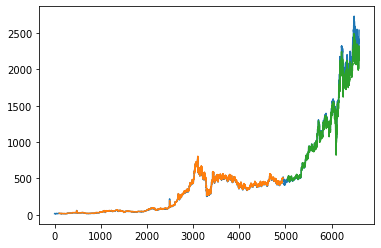

In [21]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [22]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 1309)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()